# Experiment: Label Noise and Fairness-Performance Tradeoff
This experiment evaluates how label noise affects the tradeoff between fairness and performance in a classification task. We implement the 2LR Plugin-Approach (from Bob's paper) and analyze synthetic data under various levels of label noise.

## 1. Import Libraries

In [1]:
from random import seed, shuffle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
import sys
sys.path.insert(1, '/home/ptr@itd.local/code/fairness_triangle/tools')  # Update this path as needed
from gen_synth_data import *
from plot_helper import *
from corrupt_labels import *
from calc_metrics import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scienceplots

plt.style.use(["science", "grid"])
plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'grid.alpha': 0.7,
    'xtick.major.pad': 7
})


## 2. Configuration

In [2]:
rnd_seed = 0             # Fixed randomness for reproducability
flip_prob = 0.1          # Binary Label Noise probability
flip_prob_0_to_1 = 0.1
flip_prob_1_to_0 = 0.3
disc_factor = np.pi/4     # Similarity of Y_sen to X
n_samples = 5000         # Number of samples per distribution (We have 2x in total)
split_ratio = 0.7        # Split into train and test set
c = 0.5                  # Cost of performance and fairness (Eq. 15 )
c_bar = 0.5  
lmd = 0.5                # Trade off between perf and fairn regressions (only used in vizualization)
lmd_start= 0
lmd_end= 1.1
lmd_interval = np.linspace(lmd_start, lmd_end, 1)
symmetric_fairness = False

## 3. Data Generation

In [3]:
X, Y, Y_sen = get_syn_data_custom([1, 1], [-1, -1], n_samples=5000, disc_factor=disc_factor, seed=rnd_seed)
    
# Split data
split_index = int(split_ratio * len(X))
X_train, X_test =                   X[:split_index],            X[split_index:]
Y_train, Y_test =                   Y[:split_index],            Y[split_index:]
Y_sen_train, Y_sen_test =           Y_sen[:split_index],        Y_sen[split_index:]
p_reg = LogisticRegression().fit(X_train, Y_train)
f_reg = LogisticRegression().fit(X_train, Y_sen_train)

print(np.mean(Y == 1), np.mean(Y_sen == 1))

0.5 0.4881


## 4. Model Training

_________________________
sym: 0.1
0.0016640437714049768
________________________
-0.0015398956814825476
0.0023242732516750354
_________________________
sym: 0.3
0.0013416607857358216
________________________
0.10168622572856899
0.0029114412567136524
_________________________
sym: 0.5
0.006982456282680952
________________________
0.20500908056679934
0.008997639706104866


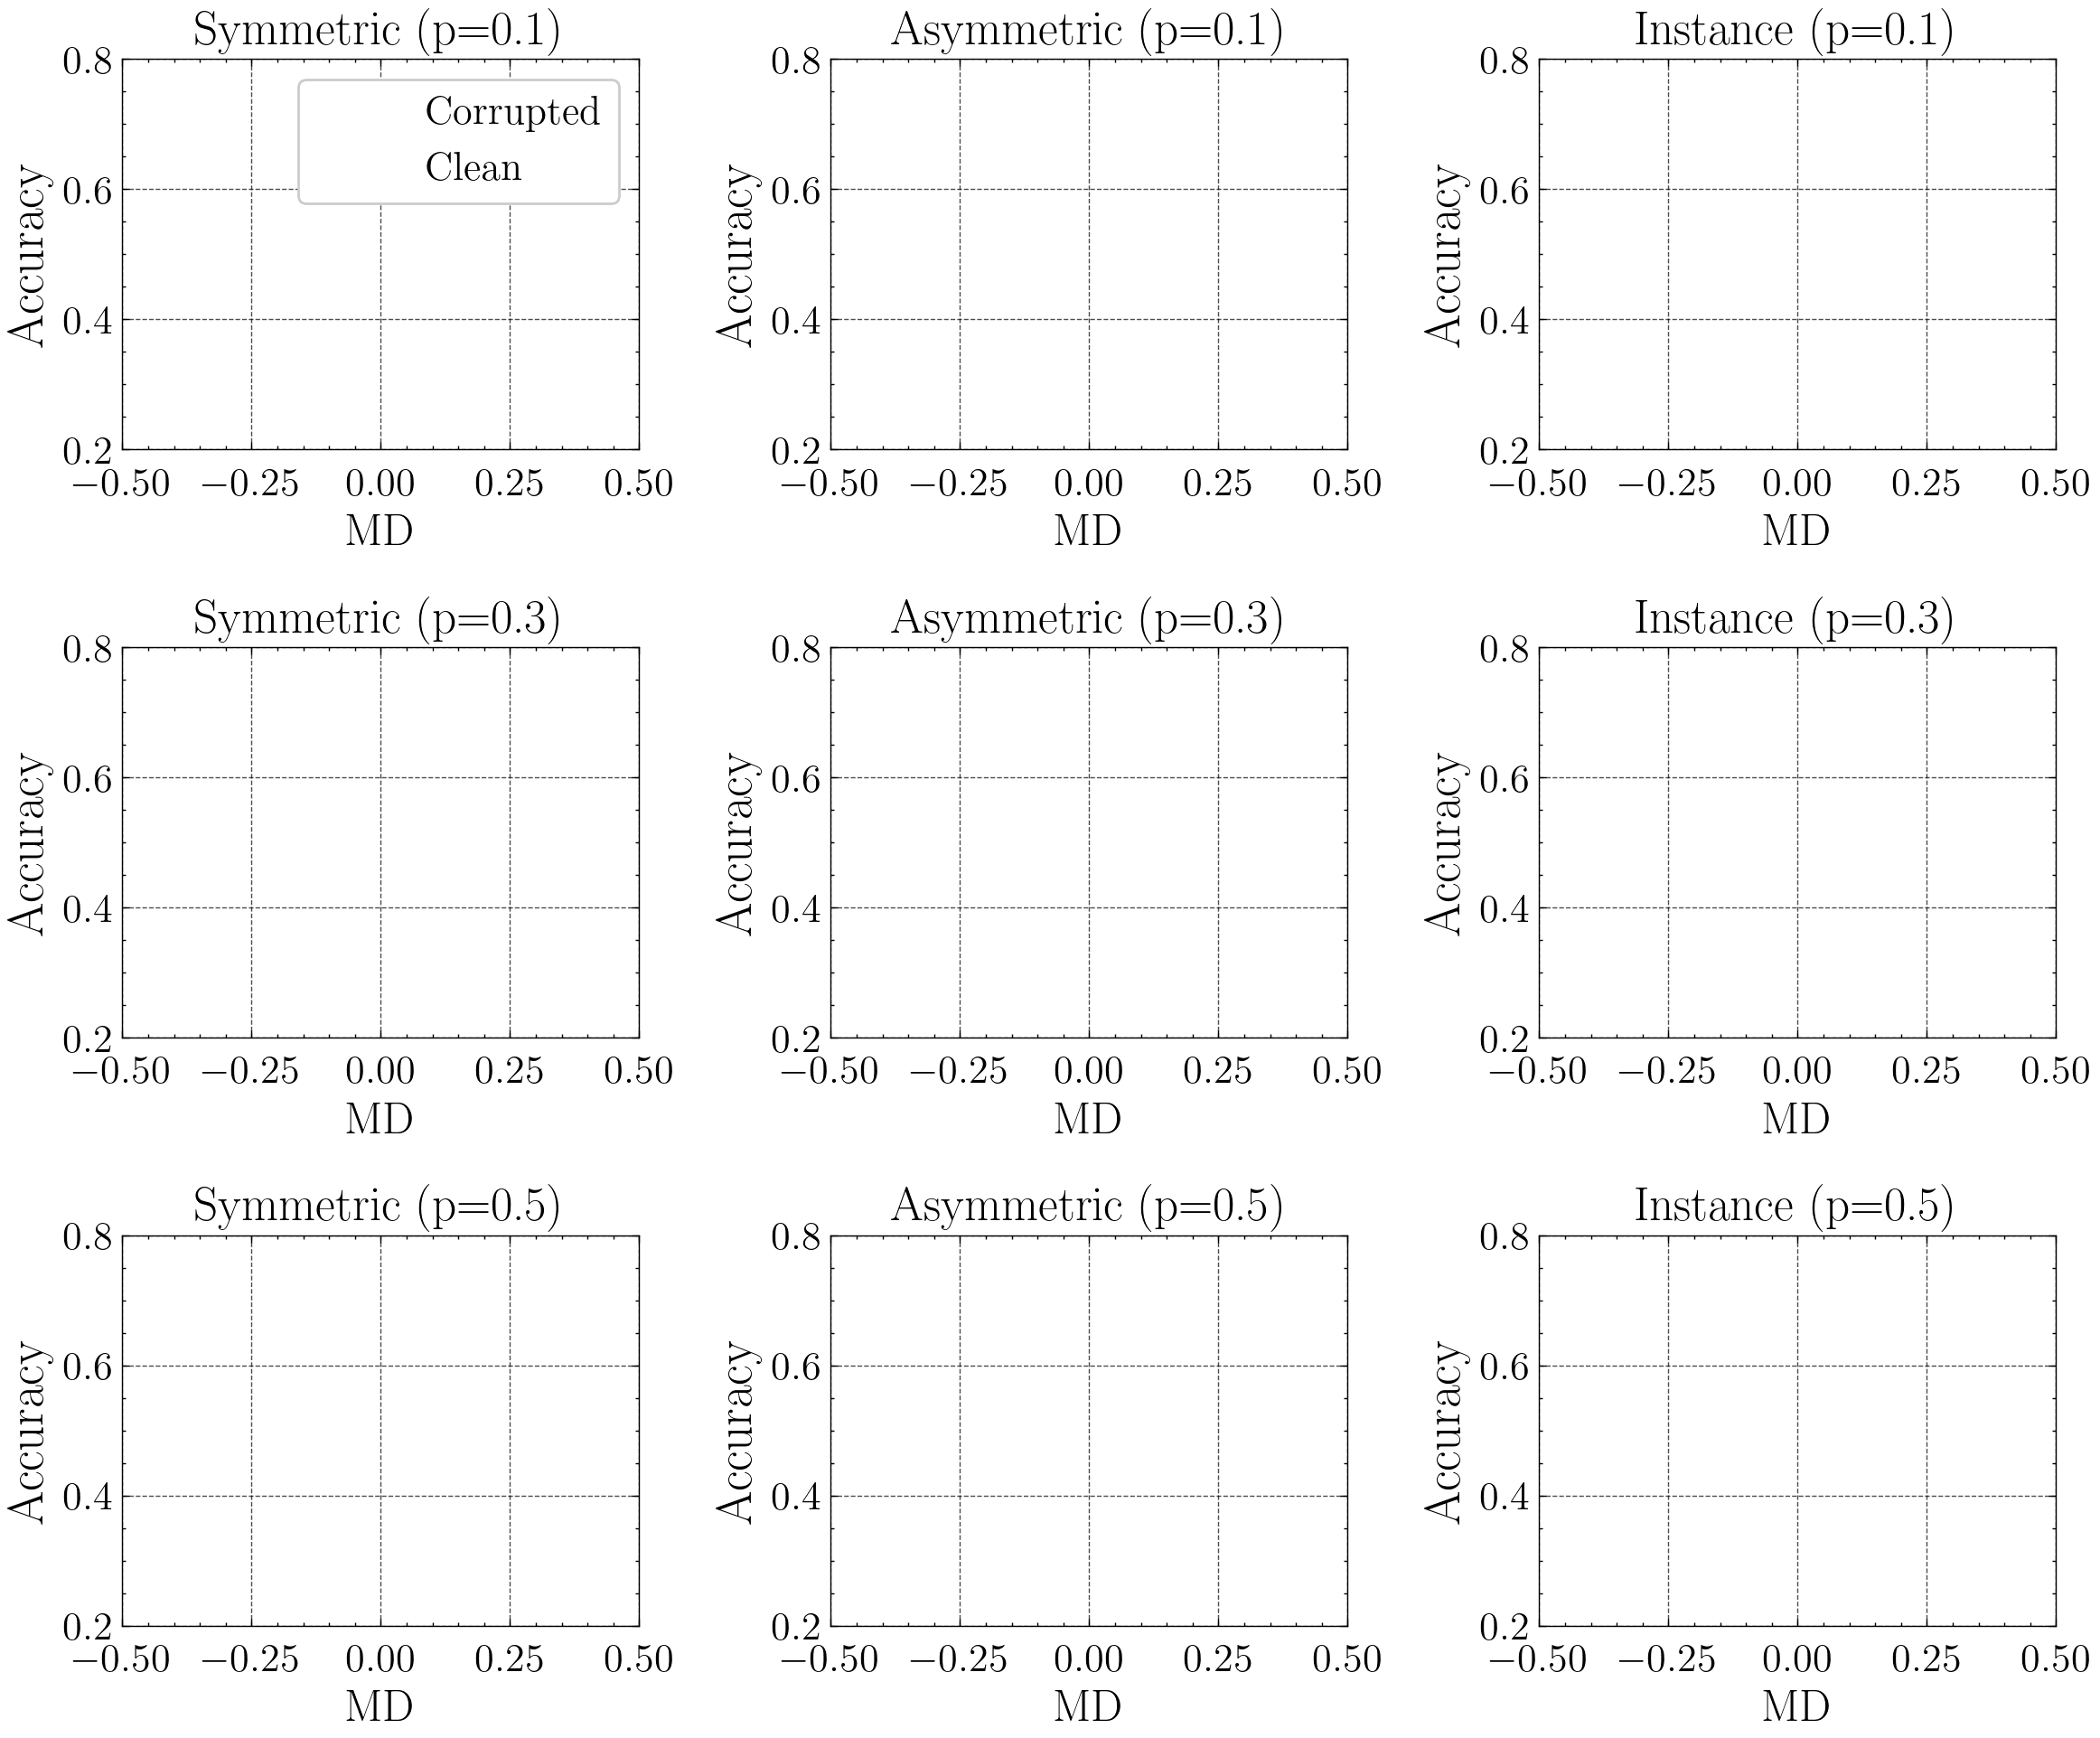

In [ ]:
def evaluate_and_plot(X_train, Y_train, X_test, Y_test, Y_sen_test,
                      Y_corrupted, p_reg, f_reg, ax, title):
    # fit with corrupted labels
    Y_corr_train, Y_corr_test = Y_corrupted[:split_index], Y_corrupted[split_index:]
    p_reg_cor = LogisticRegression().fit(X_train, Y_corr_train)

    # sweep over lambda
    BER_list, MD_list, ACC_list = [], [], []
    BER_list_corr, MD_list_corr, ACC_list_corr = [], [], []

    for lmd in lmd_interval:
        # clean predictions
        s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)
        Y_pred = np.where(s > 0, 1, 0)
        BER_list.append(calc_BER(Y_pred, Y_test))
        MD_list.append(calc_MD(Y_pred, Y_sen_test, symmetric_fairness))
        ACC_list.append(calc_ACC(Y_pred, Y_test))

        # corrupted predictions
        s2 = p_reg_cor.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)
        Y_pred2 = np.where(s2 > 0, 1, 0)
        BER_list_corr.append(calc_BER(Y_pred2, Y_test))
        MD_list_corr.append(calc_MD(Y_pred2, Y_sen_test, symmetric_fairness))
        ACC_list_corr.append(calc_ACC(Y_pred2, Y_test))
        
        print(np.mean(Y_pred2 == 1) * 100)
        print(np.mean(s2))
    # pack results (now MD instead of DI)
    results = pd.DataFrame({
        "lambda": lmd_interval,
        "ACC_clean": ACC_list, "ACC_corr": ACC_list_corr,
        "MD_clean": MD_list, "MD_corr": MD_list_corr,
    })

    # plot MD vs ACC
    df = results.sort_values("lambda")
    lambda_norm = (df["lambda"] - df["lambda"].min()) / (df["lambda"].max() - df["lambda"].min())
    orange_cmap = truncate_colormap('Oranges', 0.2, 1.0)
    green_cmap = truncate_colormap('Greens', 0.2, 1.0)

    ax.plot(df["MD_corr"], df["ACC_corr"], color="forestgreen", linewidth=2)
    ax.plot(df["MD_clean"], df["ACC_clean"], color="darkorange", linewidth=2)
    

    ax.scatter(df["MD_corr"], df["ACC_corr"], c=lambda_norm, cmap=green_cmap, s=28, label="Corrupted", marker="s")
    ax.scatter(df["MD_clean"], df["ACC_clean"], c=lambda_norm, cmap=orange_cmap, s=28, label="Clean")
    

    ax.set_title(title)
    ax.set_xlim(-0.5, 0.5); ax.set_ylim(0.2, 0.8)
    ax.set_xlabel("MD", fontsize=18)
    ax.set_ylabel("Accuracy", fontsize=20)




# =======================
# Now build the 3x3 grid
# =======================

p_values = [0.1, 0.3, 0.5]
p_2_values = [0.1, 0.1, 0.1]
noise_types = ["symmetric", "asymmetric", "instance"]

fig, axes = plt.subplots(len(p_values), len(noise_types), figsize=(12, 10))

for i, p in enumerate(p_values):
    for j, noise_type in enumerate(noise_types):
        # generate corrupted labels
        if noise_type == "symmetric":
            print("_________________________")
            print("sym:", p)
            Y_corr = add_sym_noise(Y, p, rnd_seed)
        elif noise_type == "asymmetric":
            Y_corr = add_asym_noise(Y, p, p_2_values[i], rnd_seed) 
            # adapt flipping rules
        elif noise_type == "instance":
            w, b = p_reg.coef_[0], p_reg.intercept_[0]
            Y_corr = add_instance_dependent_noise(X, Y, w, b, max_flip_prob=p,alpha=0.0002, seed=rnd_seed)

        title = f"{noise_type.capitalize()} (p={p})"
        evaluate_and_plot(X_train, Y_train, X_test, Y_test, Y_sen_test,
                          Y_corr, p_reg, f_reg, axes[i, j], title)
        if(noise_type == "symmetric"):
            print("________________________")
        
        if i == 0 and j == 0:
            axes[i, j].legend()

fig.tight_layout()
plt.savefig("../img/Used_In_MT/different_noises.png", dpi=600, bbox_inches="tight")
plt.show()


## 7. Reproducibility Notes
- Python version: 3.11.5
- Libraries: numpy, matplotlib, sklearn, pandas
- Custom modules: `gen_synth_data`, `plot_helper`, etc.
- Random seed: 0
